In [9]:
import csv
import time
import math
import numpy as np
import scipy.io
import pandas as pd
from matplotlib import pyplot as plt
from os import listdir
from os.path import dirname, join
from numpy import log, polyfit, sqrt, std, subtract
from hurst import compute_Hc
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr
from datetime import datetime
import sys
import seaborn

In [2]:
mat_files = listdir('E:/projects/connectome/data/FMRI_820subs/run2')
print("Total number of files found: "+str(len(mat_files)))

# loop through all files to extract ROI time-series from each subject and store in the tensor matrix subjects[]
subject_ts=[]
# define file directory
input_files_dir = 'E:/projects/connectome/data/FMRI_820subs/run2'
for mat_file in mat_files:
    file_name = join(input_files_dir,mat_file)
    temp = scipy.io.loadmat(file_name)  
    subject_ts.append(temp['tc'])
    
print("Total number of files loaded: "+str(len(subject_ts)))

Total number of files found: 820
Total number of files loaded: 820


In [3]:
# order_and_weight = models_weights[region] stores the weights of ARMA models for a subject
order_and_weight = [None for _ in range(len(subject_ts[0][0]))]
# Rscore = Rscore[region] stores the Pearson correlation between fitted ARMA models and original time-series
Rscore = [[None for _ in range(len(subject_ts[0][0]))] for _ in range(len(subject_ts))]
# ensemble_model = ensemble_model[region] stores the ensemble ARMA models for each resion
ensemble_ts = [None for _ in range(len(subject_ts[0][0]))] 
# Each of the model orders, paired with its model_weights as a tuple, Rscore and ensemble_model will be updated in each loop step and stored in files before they get updated

In [4]:
# Function computeWeights compute the corresponding model weights with their AIC scores
def computeWeights(AIC):
    min_AIC = min(AIC)
    AIC = np.array(AIC)
    prob = []
    for i in range(len(AIC)):
        prob.append(math.exp((min_AIC-AIC[i])/2))
    prob = np.array(prob)
    return prob/sum(prob)

def computeEnsemble(models,weights):
    ensemble=np.array([0 for _ in range(len(models[0]))])
    for i in range(len(models)):
        ensemble = ensemble + np.array(models[i])*weights[i]
    return list(ensemble)

In [5]:
d = 0 # Due to stationarity test results our time-series are stationary (possibly with fractional integration order) so we do not difference
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print('Computation started at '+ str(current_time))
p_max = 15
q_max = 6
for sub in range(1): # only 41 subjects in each stack
    for reg in range(0,160):
        ts = subject_ts[sub][:,reg]
        #PACF=stattools.pacf(ts) # use partial auto-correlation to determine the differencing order
        #if abs(PACF[1])>0.2:
        #    d=1 # if the lag-1 autocorrelation is strong, take an order 1-differencing
        #else:
        #    d=0
        predictions = [] # a 2D array that stores the predicted values of all fitted models
        AIC = [] # an 1D array that stores AIC scores
        orders = []
        for p in range(1,p_max+1):
            try:
                q = p
                fitted_model = SARIMAX(ts,order=(p,d,q),enforce_invertibility=False).fit(disp=-1)
                predictions.append(fitted_model.predict())
                orders.append((p,d,q))
                AIC.append(fitted_model.aic)
                weights = computeWeights(AIC)
                orders_and_weights = (orders, weights)    
                print("finished fitting model for subject {} region {} with (p,d,q)=({},{},{})".format(sub, reg,p,d,q))
            except:
                print("failed to fit model for subject {} region {} with (p,d,q)=({},{},{})".format(sub, reg,p,d,q))
                continue
        
        ensemble = computeEnsemble(predictions,weights)
        Rscore[sub][reg] = pearsonr(ensemble,ts)[0]
        
        order_and_weight[reg] = orders_and_weights
        ensemble_ts[reg] = ensemble
        
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print('subject {} region {} finished at {}'.format(sub,reg,str(current_time)))

Computation started at 12:09:18
finished fitting model for subject 0 region 0 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 0 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 0 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 0 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 0 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 0 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 0 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 0 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 0 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 0 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 0 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 0 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 0 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 0 with (p,d,q)=(14,0,14)
finished fitting mod

finished fitting model for subject 0 region 7 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 7 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 7 with (p,d,q)=(15,0,15)
subject 0 region 7 finished at 12:16:56
finished fitting model for subject 0 region 8 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 8 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 8 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 8 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 8 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 8 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 8 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 8 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 8 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 8 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 8 with (p,d,q)=(11,0,11)
finished fit

finished fitting model for subject 0 region 15 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 15 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 15 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 15 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 15 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 15 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 15 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 15 with (p,d,q)=(15,0,15)
subject 0 region 15 finished at 12:24:07
finished fitting model for subject 0 region 16 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 16 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 16 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 16 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 16 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 16 with (p,d,q)=(6,

finished fitting model for subject 0 region 23 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 23 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 23 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 23 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 23 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 23 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 23 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 23 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 23 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 23 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 23 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 23 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 23 with (p,d,q)=(15,0,15)
subject 0 region 23 finished at 12:31:20
finished fitting model for subject 0 region 24 with (p,d,q)=(1,

finished fitting model for subject 0 region 30 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 30 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 30 with (p,d,q)=(15,0,15)
subject 0 region 30 finished at 12:38:17
finished fitting model for subject 0 region 31 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 31 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 31 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 31 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 31 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 31 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 31 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 31 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 31 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 31 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 31 with (p,d,q)=(11,0,1

finished fitting model for subject 0 region 38 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 38 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 38 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 38 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 38 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 38 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 38 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 38 with (p,d,q)=(15,0,15)
subject 0 region 38 finished at 12:44:53
finished fitting model for subject 0 region 39 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 39 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 39 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 39 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 39 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 39 with (p,d,q)=(6,

finished fitting model for subject 0 region 46 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 46 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 46 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 46 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 46 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 46 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 46 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 46 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 46 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 46 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 46 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 46 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 46 with (p,d,q)=(15,0,15)
subject 0 region 46 finished at 12:51:54
finished fitting model for subject 0 region 47 with (p,d,q)=(1,

finished fitting model for subject 0 region 53 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 53 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 53 with (p,d,q)=(15,0,15)
subject 0 region 53 finished at 12:58:18
finished fitting model for subject 0 region 54 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 54 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 54 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 54 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 54 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 54 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 54 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 54 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 54 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 54 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 54 with (p,d,q)=(11,0,1

finished fitting model for subject 0 region 61 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 61 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 61 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 61 with (p,d,q)=(11,0,11)
failed to fit model for subject 0 region 61 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 61 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 61 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 61 with (p,d,q)=(15,0,15)
subject 0 region 61 finished at 13:05:37
finished fitting model for subject 0 region 62 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 62 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 62 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 62 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 62 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 62 with (p,d,q)=(6,0,6

finished fitting model for subject 0 region 69 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 69 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 69 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 69 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 69 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 69 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 69 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 69 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 69 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 69 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 69 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 69 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 69 with (p,d,q)=(15,0,15)
subject 0 region 69 finished at 13:13:28
finished fitting model for subject 0 region 70 with (p,d,q)=(1,

finished fitting model for subject 0 region 76 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 76 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 76 with (p,d,q)=(15,0,15)
subject 0 region 76 finished at 13:19:47
finished fitting model for subject 0 region 77 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 77 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 77 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 77 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 77 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 77 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 77 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 77 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 77 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 77 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 77 with (p,d,q)=(11,0,1

finished fitting model for subject 0 region 84 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 84 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 84 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 84 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 84 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 84 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 84 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 84 with (p,d,q)=(15,0,15)
subject 0 region 84 finished at 13:27:01
finished fitting model for subject 0 region 85 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 85 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 85 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 85 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 85 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 85 with (p,d,q)=(6,

finished fitting model for subject 0 region 92 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 92 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 92 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 92 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 92 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 92 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 92 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 92 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 92 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 92 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 92 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 92 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 92 with (p,d,q)=(15,0,15)
subject 0 region 92 finished at 13:34:38
finished fitting model for subject 0 region 93 with (p,d,q)=(1,

finished fitting model for subject 0 region 99 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 99 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 99 with (p,d,q)=(15,0,15)
subject 0 region 99 finished at 13:41:37
finished fitting model for subject 0 region 100 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 100 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 100 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 100 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 100 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 100 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 100 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 100 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 100 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 100 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 100 with (p,d

finished fitting model for subject 0 region 107 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 107 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 107 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 107 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 107 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 107 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 107 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 107 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 107 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 107 with (p,d,q)=(15,0,15)
subject 0 region 107 finished at 13:48:37
finished fitting model for subject 0 region 108 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 108 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 108 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 108 w

finished fitting model for subject 0 region 114 with (p,d,q)=(15,0,15)
subject 0 region 114 finished at 13:54:42
finished fitting model for subject 0 region 115 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 115 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 115 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 115 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 115 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 115 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 115 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 115 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 115 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 115 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 115 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 115 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 115 with 

finished fitting model for subject 0 region 122 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 122 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 122 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 122 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 122 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 122 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 122 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 122 with (p,d,q)=(15,0,15)
subject 0 region 122 finished at 14:02:04
finished fitting model for subject 0 region 123 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 123 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 123 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 123 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 123 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 123 w

finished fitting model for subject 0 region 130 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 130 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 130 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 130 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 130 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 130 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 130 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 130 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 130 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 130 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 130 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 130 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 130 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 130 with (p,d,q)=(14,0,14)
finished fitting model f

finished fitting model for subject 0 region 137 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 137 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 137 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 137 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 137 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 137 with (p,d,q)=(15,0,15)
subject 0 region 137 finished at 14:15:48
finished fitting model for subject 0 region 138 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 138 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 138 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 138 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 138 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 138 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 138 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 138 w

finished fitting model for subject 0 region 145 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 145 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 145 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 145 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 145 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 145 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 145 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 145 with (p,d,q)=(10,0,10)
finished fitting model for subject 0 region 145 with (p,d,q)=(11,0,11)
finished fitting model for subject 0 region 145 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 145 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 145 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 145 with (p,d,q)=(15,0,15)
subject 0 region 145 finished at 14:23:19
finished fitting model for subject 0 region 146 w

finished fitting model for subject 0 region 152 with (p,d,q)=(12,0,12)
finished fitting model for subject 0 region 152 with (p,d,q)=(13,0,13)
finished fitting model for subject 0 region 152 with (p,d,q)=(14,0,14)
finished fitting model for subject 0 region 152 with (p,d,q)=(15,0,15)
subject 0 region 152 finished at 14:29:58
finished fitting model for subject 0 region 153 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 153 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 153 with (p,d,q)=(3,0,3)
finished fitting model for subject 0 region 153 with (p,d,q)=(4,0,4)
finished fitting model for subject 0 region 153 with (p,d,q)=(5,0,5)
finished fitting model for subject 0 region 153 with (p,d,q)=(6,0,6)
finished fitting model for subject 0 region 153 with (p,d,q)=(7,0,7)
finished fitting model for subject 0 region 153 with (p,d,q)=(8,0,8)
finished fitting model for subject 0 region 153 with (p,d,q)=(9,0,9)
finished fitting model for subject 0 region 153 with 

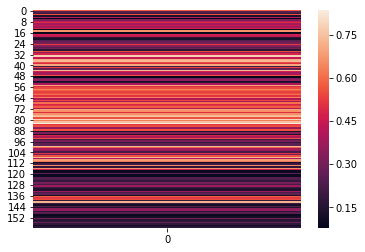

In [11]:
seaborn.heatmap(pd.DataFrame(Rscore[0]))
plt.show()

In [ ]:
def plotTS(original_ts,sub,reg,start=0,end=100,fitted_ts1=None,fitted_ts2=None):
    # sub: subject ID, an 6-digit number, data type:int
    # reg: region number, data type: int
    # start, end: starting point and end point of the time-series that is to be plotted, data type:int
    fitted1 = fitted2 = None
    if fitted_ts1:
        fitted1 = fitted_ts1[ID_to_row_num['sub'+str(sub)]][reg,:][start:end]
    if fitted_ts2:
        fitted2 = fitted_ts2[ID_to_row_num['sub'+str(sub)]][reg,:][start:end]
        
    original = original_ts[ID_to_row_num['sub'+str(sub)]][:,reg][start:end]
    if any(fitted1):
        plt.plot(fitted1, color='g',label='fitted_ensemble1')
    if any(fitted2):
        plt.plot(fitted2,color='b',label='fitted_ensemble2')
        
    plt.plot(original, color='r', label='original' )
    plt.legend()
    plt.show()

In [ ]:
plt.plot(subject_ts[1][:,3][:1200],color='g',label='original')
plt.plot(ensemble_ts[3][0:1200],color='r',label='fitted_ensemble')
plt.legend()
plt.show()

In [ ]:
pearsonr(ensemble_ts[3],subject_ts[1][:,3])[0]

In [ ]:
order_and_weight[3]

In [ ]:
sub_orders_and_weights[3]

In [ ]:
file_dir = 'E:/projects/connectome/results/HurstExp_ARMA_results_0_to_5/ensemble_orders_and_weights'
file_names = listdir(file_dir)
file_names

In [ ]:
file_name= 'ensemble_orders_and_weights_100307.mat'
file = join(file_dir,file_name)
sub_orders_and_weights = scipy.io.loadmat(file)['ensemble_orders_and_weights']

In [164]:
grid = [['.','.'], 
        ['.','.']]
queen_count = 0

In [165]:
def isValidPlacement(grid, x , y):
    for j in range(len(grid[0])):
        if grid[x][j] == 'Q':
            return False
    for i in range(len(grid)):
        if grid[i][y] == 'Q':
            return False
        
    for i in range(-len(grid),len(grid),1):
        if x + i < len(grid) and y + i < len(grid) and grid[x+i][y+i] == 'Q':
            return False
    for i in range(-len(grid),len(grid),1):
        if x - i < len(grid) and y + i < len(grid) and grid[x-i][y+i] == 'Q':
            return False
    
    return True

In [166]:
def solve(grid):
    global queen_count
    while queen_count<2:
        for i in range(len(grid)):
            for j in range(len(grid)):
                if grid[i][j] == '.' and isValidPlacement(grid, i, j):
                    grid[i][j] = 'Q'
                    queen_count += 1
                    if queen_count<=2:
                        solve(grid)
                    return
                    queen_count -= 1
                    grid[i][j] = '.'
    print(np.matrix(grid))
    


In [374]:
import random
import itertools

In [351]:
test = set([1,2,3])

In [353]:
random.sample(test,1)[0]

1

In [384]:
success_count = 0
tot_tests = 100000
for _ in range(tot_tests):
    available_seats = set(range(1,101))
    available_seats.remove(random.randrange(1,101))
    for i in range(2,100):
        if i in available_seats:
            available_seats.remove(i)
        else:
            next_taken_seat = random.sample(available_seats,1)[0]
            available_seats.remove(next_taken_seat)
        if i == 99 and 100 in available_seats:
            success_count += 1
    
print(success_count/float(tot_tests))                

0.50179


In [411]:
%%timeit
x = []
for i in range(10000000):
    x.append(i)

803 ms ± 4.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [412]:
%%timeit
x = [None]*10000000
for i in range(10000000):
    x[i] = i

469 ms ± 1.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
